# AI-based OCR Benchmark Notebook

This notebook benchmarks **AI-based OCR models** on scanned PDF documents/images in Spanish.
It excludes traditional OCR engines like Tesseract that require external installations.

In [1]:
%pip install --upgrade pip
%pip install --upgrade jupyter
%pip install --upgrade ipywidgets
%pip install -U ipykernel

# Install necessary packages
%pip install easyocr transformers torch pdf2image pillow jiwer paddleocr hf_xet paddlepaddle
# pdf reading
%pip install PyMuPDF

# Data analysis and visualization
%pip install pandas
%pip install matplotlib
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https:/

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageOps
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from jiwer import wer, cer
from paddleocr import PaddleOCR
import fitz  # PyMuPDF

## 1 Configuration

In [3]:
PDF_FOLDER = './instructions'  # Folder containing PDF files
OUTPUT_FOLDER = 'results'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

LANGUAGES = ['es']  # OCR language(s)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# Initialize AI OCR models
easyocr_reader = easyocr.Reader(LANGUAGES)
trocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')
trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1').to(device)
paddleocr_model = PaddleOCR(lang='es', use_angle_cls=True)  # PaddleOCR in Spanish

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sji\AppData\Local\Temp\ipykernel_17700\3778845089.py:12: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  paddleocr_model = PaddleOCR(lang='es

## 2 Helper Functions

In [4]:
def pdf_to_images(pdf_path):
    return convert_from_path(pdf_path)

def ocr_easyocr(img):
    result = easyocr_reader.readtext(np.array(img))
    res = ' '.join([r[1] for r in result])
    plt.figure(figsize=(10, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(res, fontsize=10)
    plt.show()
    return res

def pdf_extract_text(pdf_path, page_num) -> str:
    """
    Extracts text from a specific PDF page in proper reading order.
    """
    doc = fitz.open(pdf_path)
    
    if page_num < 1 or page_num > len(doc):
        return ""
    
    page = doc[page_num - 1]
    blocks = page.get_text("blocks")  # returns list of (x0, y0, x1, y1, "text", block_no, block_type)
    
    # Sort blocks top-to-bottom, left-to-right
    blocks_sorted = sorted(blocks, key=lambda b: (b[1], b[0]))  # y0, then x0
    
    text = " ".join([b[4].replace('\n', ' ').strip() for b in blocks_sorted])
    return text

def evaluate_text(reference, prediction):
    return {'WER': wer(reference, prediction), 'CER': cer(reference, prediction)}

## 3 Run AI OCR Benchmark

c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


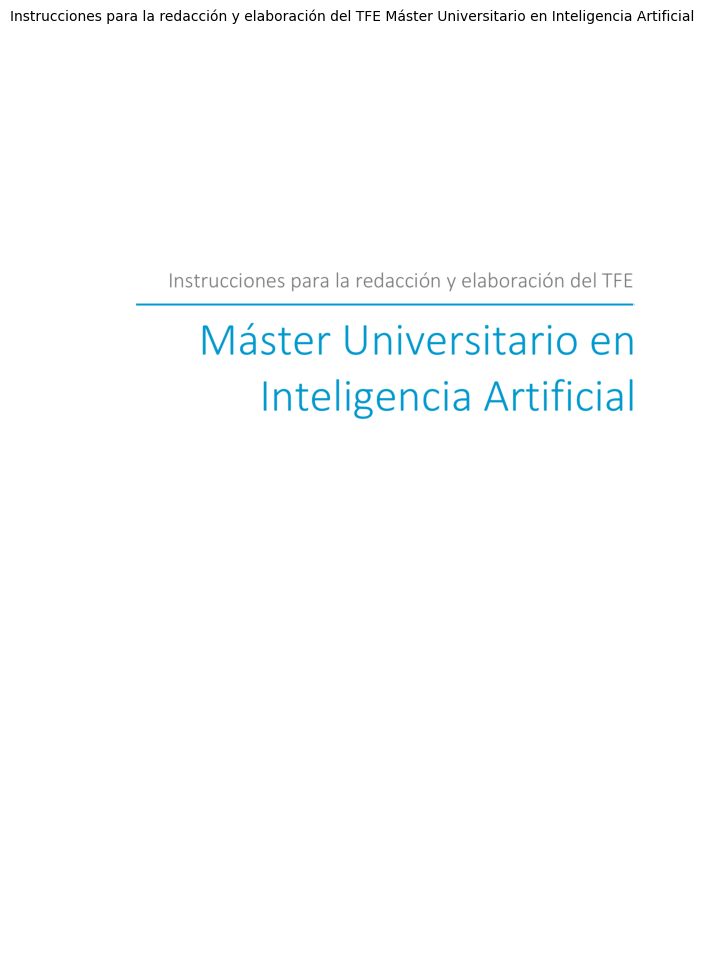

[2025-10-08 12:29:47,364] [ WARNING] image.py:661 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


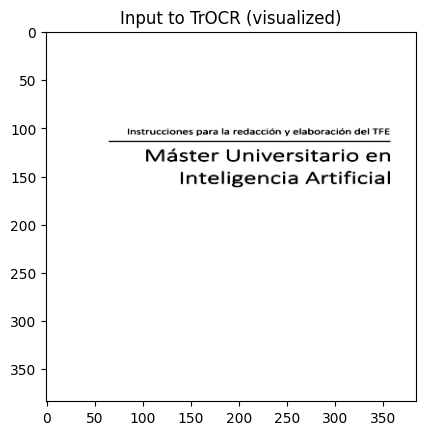

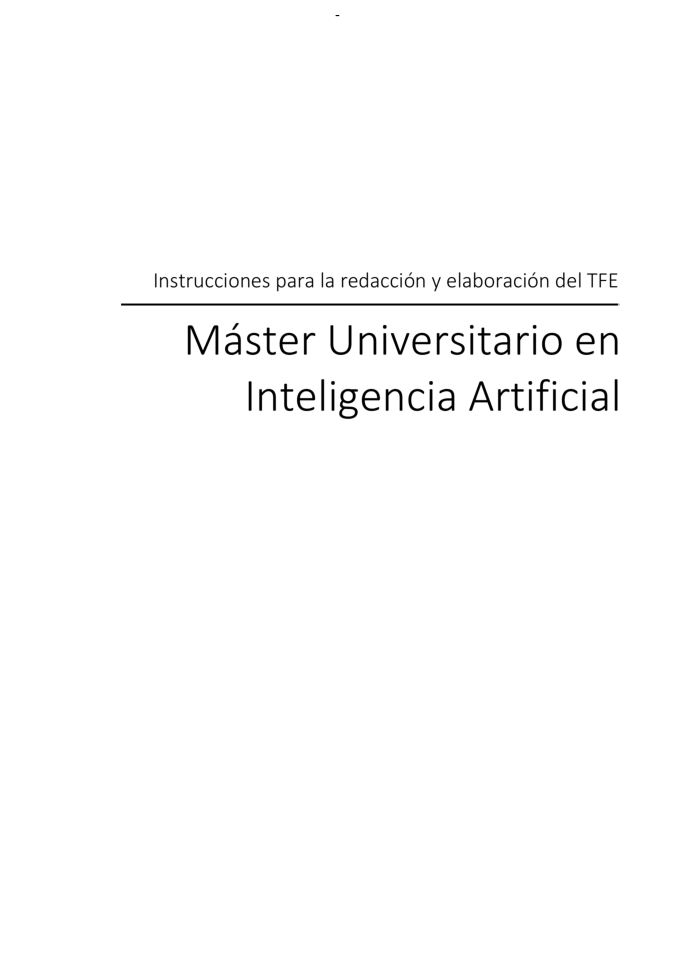

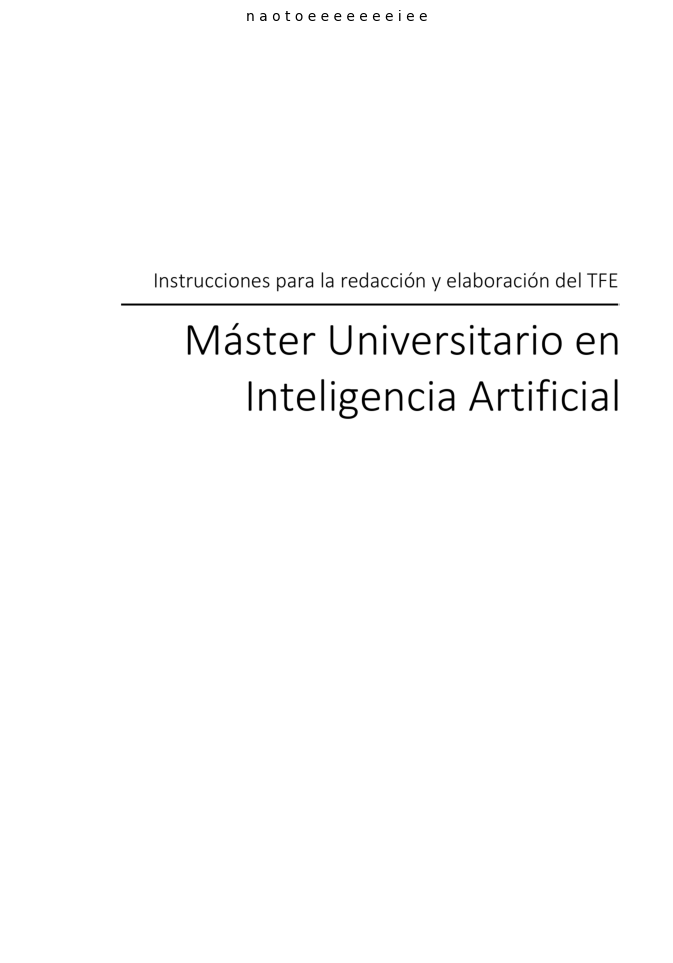

In [5]:
def ocr_trocr(img):
    img_gray = img.convert('L')
    img_bin = ImageOps.autocontrast(img_gray, cutoff=1)  # boost faint text
    img_proc = img_bin.convert('RGB')

    # TrOCR expects a list of images
    pixel_values = trocr_processor(images=[img_proc], return_tensors="pt").pixel_values
    
    # Generate text
    generated_ids = trocr_model.generate(pixel_values)
    
    plt.imshow(pixel_values[0].permute(1,2,0).cpu().numpy())
    plt.title("Input to TrOCR (visualized)")
    plt.show()
    # Decode
    res = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Show image with OCR text as title
    plt.figure(figsize=(10, 12))
    plt.imshow(img_proc)
    plt.axis('off')
    plt.title(res, fontsize=10)
    plt.show()
    return res

def ocr_paddle(img):
    img_gray = img.convert('L')
    img_bin = ImageOps.autocontrast(img_gray, cutoff=1)  # boost faint text
    img_proc = img_bin.convert('RGB')
    result = paddleocr_model.predict(np.array(img_proc))
    res = ' '.join([line[1][0] for page in result for line in page])

    # Show the processed image
    plt.figure(figsize=(10, 12))
    plt.imshow(img_proc)
    plt.axis('off')
    plt.title(res, fontsize=10)
    plt.show()
    return res


results = []

for pdf_file in os.listdir(PDF_FOLDER):
    if not pdf_file.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    images = pdf_to_images(pdf_path)
    
    for i, img in enumerate(images):
        if i != 0:
            break
        page_num = i+1
        ref = pdf_extract_text(pdf_path, page_num=page_num)
        
        # EasyOCR
        easy_text = ocr_easyocr(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'EasyOCR', 'Prediction': easy_text, **evaluate_text(ref, easy_text)})
        
        # TrOCR
        trocr_text = ocr_trocr(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'TrOCR', 'Prediction': trocr_text, **evaluate_text(ref, trocr_text)})
        
        # PaddleOCR
        paddle_text = ocr_paddle(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'PaddleOCR', 'Prediction': paddle_text, **evaluate_text(ref, paddle_text)})

## 4 Save and Analyze Results

Benchmark results saved!
                WER       CER
Model                        
EasyOCR    0.000000  0.000000
PaddleOCR  1.153846  0.782178
TrOCR      1.000000  1.000000


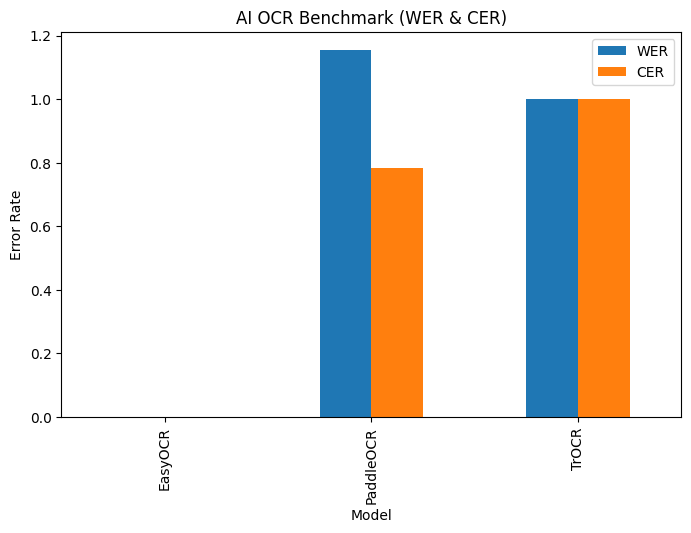

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_FOLDER, 'ai_ocr_benchmark_results.csv'), index=False)
print('Benchmark results saved!')

# Summary by model
summary = df_results.groupby('Model')[['WER', 'CER']].mean()
print(summary)

# Plot
summary.plot(kind='bar', figsize=(8,5), title='AI OCR Benchmark (WER & CER)')
plt.ylabel('Error Rate')
plt.show()